In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import os
print(f"Current working directory: {os.getcwd()}")
print(f"Directory exists: {os.path.exists('parsed csvs')}")
print(f"Is directory: {os.path.isdir('parsed csvs')}")
all_files = glob.glob(os.path.join("parsed csvs", "plays_by_*.csv"))
print(f"Number of files found: {len(all_files)}")
print(f"First few files found: {all_files[:5] if all_files else 'None'}")

Current working directory: /Users/michaelgelberg/Desktop/spring-2025
Directory exists: True
Is directory: True
Number of files found: 722
First few files found: ['parsed csvs/plays_by_city_1711474240_20240712.csv', 'parsed csvs/plays_by_city_1711474234_20241206.csv', 'parsed csvs/plays_by_city_1711474233_20241004.csv', 'parsed csvs/plays_by_city_1711474243_20240524.csv', 'parsed csvs/plays_by_city_1711474237_20241018.csv']


In [4]:

def extract_week_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[-1].replace(".csv","") #last part is the week

def extract_song_id_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[-2].replace(".csv","") #second to last part is the song id

def extract_group_by_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[-3].replace(".csv","") #third to last part is the group by value

def extract_measure_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[0]

def load_all_csvs():
    all_files = glob.glob(os.path.join("parsed csvs", "*_by_*.csv"))
    dataframes = []
    empty_files = []
    
    for file in all_files:
        try:
            # Check if file is empty or too small
            if os.path.getsize(file) <= 1:
                print(f"Skipping empty file: {file}")
                continue
            measure = extract_measure_from_filename(file)    
            week = extract_week_from_filename(file)
            song_id = extract_song_id_from_filename(file)
            group_by = extract_group_by_from_filename(file)
            
            df = pd.read_csv(file)
            if df.empty:
                print(f"Skipping empty dataframe from: {file}")
                continue
                
            df["Week"] = week
            df["Song ID"] = song_id
            df["Grouping"] = group_by
            dataframes.append(df)
            
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
            continue
        except Exception as e:
            print(f"Error reading file {file}: {str(e)}")
            continue
    
    if empty_files:
        with open("empty_files_to_rescrape.txt", "w") as f:
            f.write("# Run these commands to re-scrape empty files:\n")
            for song_id, week in empty_files:
                command = f"python run-export.py --force {week} {song_id}\n"
                f.write(command)
        print(f"\nEmpty files list saved to empty_files_to_rescrape.txt")

    if not dataframes:
        raise ValueError("No valid data files were found!")
        
    return pd.concat(dataframes, ignore_index=True)

def build_velocity(df):
    df["Week"] = pd.to_datetime(df["Week"], format="%Y%m%d")
    df.sort_values(by=["Grouping","City","Song ID","Week"], inplace=True)

    df["Δ Plays"] = df.groupby(["Grouping","Song ID","City"])["Current Period"].diff()
    df["% Δ"] = df.groupby(["Grouping","Song ID","City"])["Current Period"].pct_change() * 100
    return df
    

def main():
    df = load_all_csvs()
    df = build_velocity(df)
    df.to_csv("song_velocity_table.csv", index=False)
    print("✅ song_velocity_table.csv created with week-over-week changes")

if __name__ == "__main__":
    main()






Skipping empty file: parsed csvs/plays_by_city_1711474234_20241206.csv
Skipping empty file: parsed csvs/plays_by_city_1711474241_20240503.csv
Skipping empty file: parsed csvs/plays_by_city_1711474240_20250307.csv
Skipping empty file: parsed csvs/plays_by_city_1711474243_20250131.csv
Skipping empty file: parsed csvs/plays_by_city_1711474243_20250124.csv
Skipping empty file: parsed csvs/plays_by_city_1711474239_20240426.csv
Skipping empty file: parsed csvs/plays_by_city_1711474241_20250117.csv
Skipping empty file: parsed csvs/plays_by_city_1711474234_20241213.csv
Skipping empty file: parsed csvs/plays_by_city_1711474241_20241018.csv
Skipping empty file: parsed csvs/plays_by_city_1711474242_20241206.csv
Skipping empty file: parsed csvs/plays_by_city_1711474235_20250131.csv
Skipping empty file: parsed csvs/plays_by_city_1711474239_20240419.csv
Skipping empty file: parsed csvs/plays_by_city_1748029276_20240705.csv
Skipping empty file: parsed csvs/plays_by_city_1711474241_20241227.csv
Skippi

In [6]:
df = pd.read_csv('song_velocity_table.csv', parse_dates=["Week"])
df[(df.City=="All Cities") & (df.Measure=="listeners")].head()

,City,Previous Period,Current Period,% Change,Week,Song,Song ID,Grouping,Measure,Δ Plays,% Δ
666,All Cities,4,6,+50%,2025-04-04,Althea,1748029276,city,listeners,-1.0,-14.285714
668,All Cities,6,16,+167%,2025-04-11,Althea,1748029276,city,listeners,-3.0,-15.789474
672,All Cities,257,39,-85%,2025-04-04,That Thing,1807227251,city,listeners,-14.0,-26.415094
674,All Cities,39,162,+315%,2025-04-11,That Thing,1807227251,city,listeners,-18.0,-10.000000


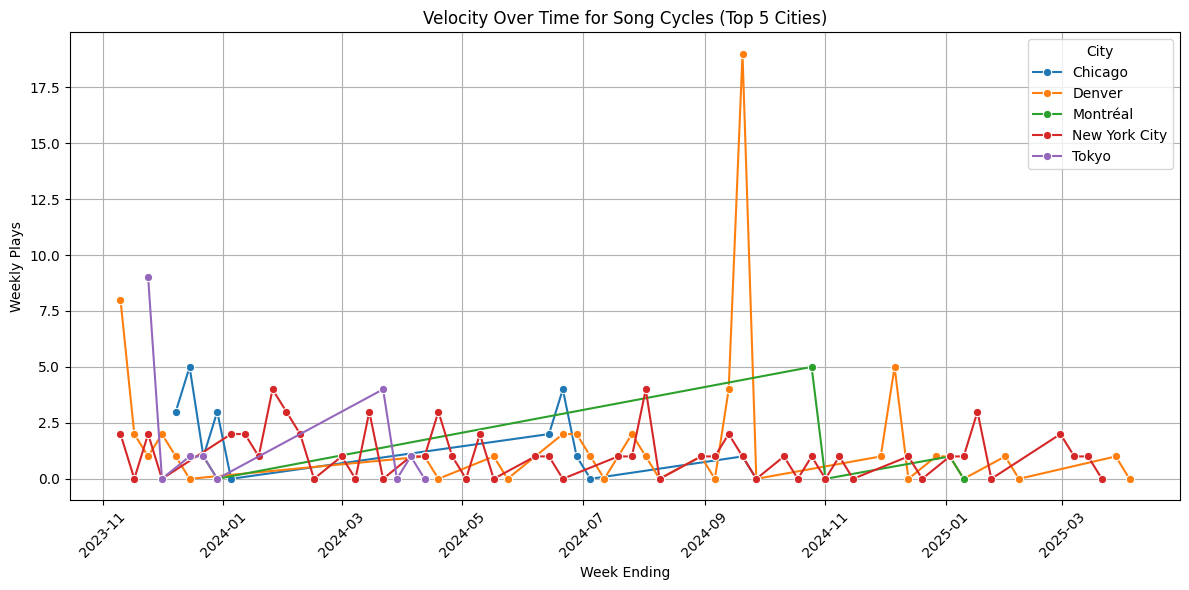

In [72]:
# 👇 Set your target song_id and group_by
target_song_name = "Cycles"
group_by_value = "city"

# Filter for this song and group
filtered = df[(df["Song"] == target_song_name) & (df["Grouping"] == group_by_value) & (df["City"] != "All Cities")]

# Identify top 5 cities by max plays
top_cities = (
    filtered.groupby("City")["Current Period"]
    .max()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Subset data to only top cities
top_city_data = filtered[filtered["City"].isin(top_cities)]

# Set up the plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=top_city_data,
    x="Week",
    y="Current Period",
    hue="City",
    marker="o"
)

plt.title(f"Velocity Over Time for Song {target_song_name} (Top 5 Cities)")
plt.xlabel("Week Ending")
plt.ylabel("Weekly Plays")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend(title="City")
plt.show()
